In [1]:
# from google.colab import drive
# drive.mount('/content/drive')  # use this if you are using google colab

In [2]:
from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.manifold import TSNE
import pickle, os
import numpy as np
import matplotlib.pyplot as plt

In [3]:
def load_dataset(name_file):

    desired_directory = '.' # Replace with your desired directory path

    file_path = os.path.join(desired_directory, name_file) 

    with open(file_path, 'rb') as f:
        data_dict = pickle.load(f)

    return data_dict


In [4]:
loaders_dict = load_dataset(f"dataset-flowers102-features.pkl")
x_train = loaders_dict["x_train"]
x_test = loaders_dict["x_test"]
y_train = loaders_dict["y_train"]
y_test = loaders_dict["y_test"]
print(f"x_train:{x_train.shape}, y_train:{y_train.shape}")
print(f"x_test:{x_test.shape}, y_test:{y_test.shape}")


x_train:(4094, 512), y_train:(4094,)
x_test:(4095, 512), y_test:(4095,)


## clustering images

In [5]:
k_number = 50
kmeans = KMeans(n_clusters=k_number)
clusters = kmeans.fit_predict(x_train)
centroids = kmeans.cluster_centers_

c:\Users\ewint\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


## find nearest clusters neighbors

### find nearest clusters and their indices

In [6]:
def find_nearest_clusters_neighbors(x_train, x_test, k):
    knn_classifier = KNeighborsClassifier(n_neighbors=k)
    knn_classifier.fit(x_train, range(len(x_train)))
    nearest_indices = knn_classifier.kneighbors(x_test, n_neighbors=k, return_distance=False)
    # nearest_neighbors = x_train[nearest_indices]
    # nearest_neighbors = [x_train[indices] for indices in nearest_indices]

    return nearest_indices

### get the data of nearest clusters

In [7]:
def gather_clusters_data(k_number, clusters):
    clusters_data = {i: [] for i in range(k_number)}
    clusters_data_labels = {i: [] for i in range(k_number)}
    for i, label in enumerate(clusters):
        clusters_data[label].append(x_train[i])
        clusters_data_labels[label].append(y_train[i])
    return clusters_data, clusters_data_labels

In [8]:
def get_nearest_clusters_data(nearest_clusters_indices, clusters_data, clusters_data_labels):
    # Access data points in the cluster with centroid index 'nearest_clusters_indices'
    all_data_in_nearest_clusters = []
    all_labels_in_nearest_clusters = []
    for indices in nearest_clusters_indices:
        data_in_nearest_clusters = []
        labels_in_nearest_clusters = []
        for index in indices:
            data_in_nearest_clusters.extend(clusters_data[index])
            labels_in_nearest_clusters.extend(clusters_data_labels[index])
        all_data_in_nearest_clusters.append(data_in_nearest_clusters)
        all_labels_in_nearest_clusters.append(labels_in_nearest_clusters)
    return all_data_in_nearest_clusters, all_labels_in_nearest_clusters

## classify using data in nearest clusters

In [9]:
def classify_knn(x_train, y_train, x_test, y_test, k):
    y_preds = []
    for data_train, label_train, one_data_test in zip(x_train, y_train, x_test):
        knn_classifier = KNeighborsClassifier(n_neighbors=k)
        knn_classifier.fit(data_train, label_train)
        y_preds.append(knn_classifier.predict([one_data_test]))
    
    accuracy = accuracy_score(y_test, y_preds)
    score = ( accuracy * 100 ) + ( k * (-0.2))
    return y_preds, accuracy, score

## running classifying steps using different amout of *k_nearest_clusters* and *k_nearest_data*

In [16]:
first_k_results = {}
k_clusters = range(5, 15, 1)
k_data = range(3, 8, 1)

for k_nearest_clusters in k_clusters:
    print("-", k_nearest_clusters)
    second_k_results = {} # first element in each touple is accuracy and the second one is score
    # find nearest klisters neighbors----------------------------------
    x_train_clusters = centroids
    nearest_clusters_indices = find_nearest_clusters_neighbors(x_train_clusters, 
                                                            x_test, 
                                                            k=k_nearest_clusters)
    # gather clusters data---------------------------------------------
    clusters_data, clusters_data_labels = gather_clusters_data(k_number, clusters)
    # get nearest clusters data----------------------------------------
    all_data_in_nearest_clusters, all_labels_in_nearest_clusters = get_nearest_clusters_data(nearest_clusters_indices, 
                                                                                    clusters_data, 
                                                                                    clusters_data_labels)
    for k_nearest_data in k_data:
        if k_nearest_data > len(all_data_in_nearest_clusters):
            break

        print("-   -", k_nearest_data)
        # classify test data using knn-------------------------------------
        x_train_data = all_data_in_nearest_clusters
        y_train_data = all_labels_in_nearest_clusters
        predictions, accuracy, score = classify_knn(x_train_data, y_train_data, x_test, y_test, k=k_nearest_data)
        # result-----------------------------------------------------------
        second_k_results[k_nearest_data] = (accuracy*100, score)
    
    first_k_results[k_nearest_clusters] = second_k_results
    print(first_k_results[k_nearest_clusters])
print(np.array(first_k_results))    

- 5
-   - 3
-   - 4
-   - 5
-   - 6
-   - 7
{3: (84.004884004884, 83.40488400488401), 4: (84.49328449328449, 83.6932844932845), 5: (84.85958485958486, 83.85958485958486), 6: (84.73748473748473, 83.53748473748473), 7: (84.54212454212454, 83.14212454212453)}
- 6
-   - 3
-   - 4
-   - 5
-   - 6
-   - 7
{3: (84.12698412698413, 83.52698412698413), 4: (84.73748473748473, 83.93748473748474), 5: (85.12820512820512, 84.12820512820512), 6: (84.93284493284493, 83.73284493284493), 7: (84.76190476190476, 83.36190476190475)}
- 7
-   - 3
-   - 4
-   - 5
-   - 6
-   - 7
{3: (84.12698412698413, 83.52698412698413), 4: (84.71306471306471, 83.91306471306471), 5: (85.15262515262515, 84.15262515262515), 6: (85.15262515262515, 83.95262515262515), 7: (84.95726495726495, 83.55726495726495)}
- 8
-   - 3
-   - 4
-   - 5
-   - 6
-   - 7
{3: (84.02930402930403, 83.42930402930403), 4: (84.73748473748473, 83.93748473748474), 5: (85.07936507936508, 84.07936507936508), 6: (85.07936507936508, 83.87936507936507), 7: (85

## plot clusters

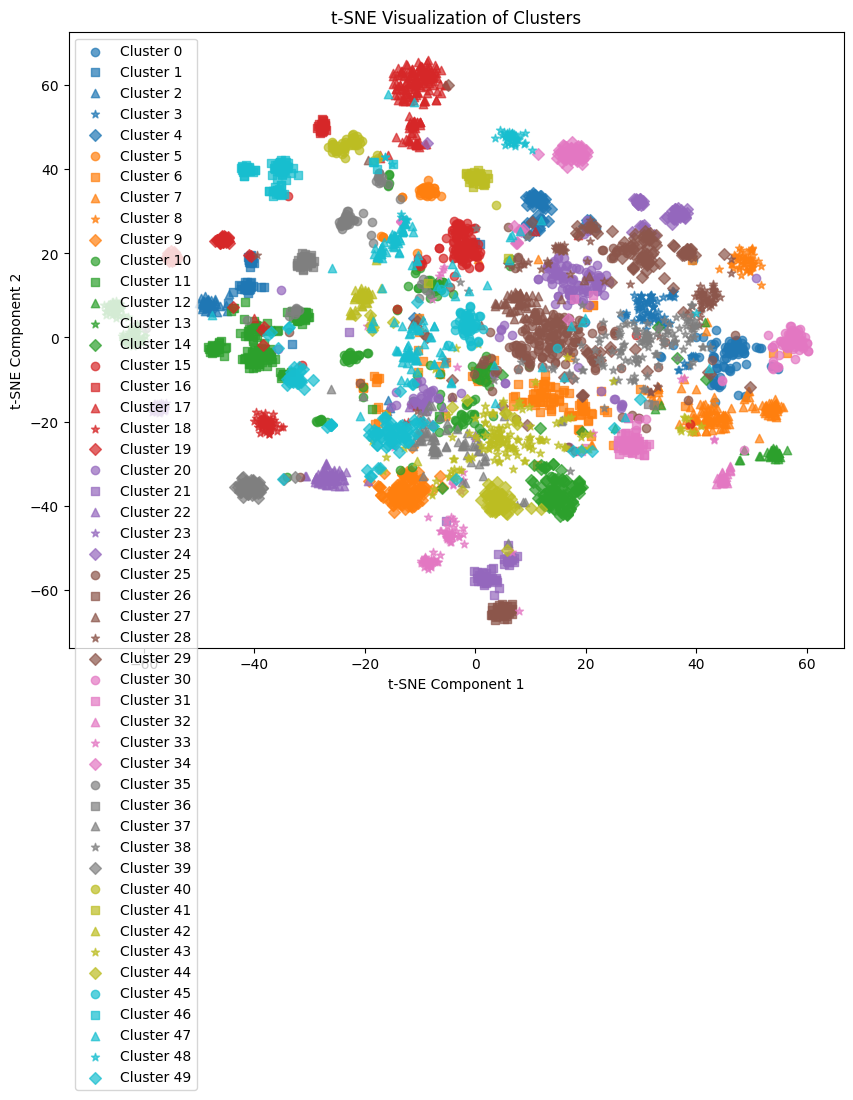

In [11]:
data = x_train
labels = clusters
# Perform t-SNE dimensionality reduction
tsne = TSNE(n_components=2, random_state=42)
embedded_data = tsne.fit_transform(data)

colormap = plt.get_cmap('tab10')  
markers = ['o', 's', '^', '*', 'D']

plt.figure(figsize=(10, 8))

for i, cluster_label in enumerate(np.unique(labels)):
    cluster_indices = np.where(labels == cluster_label)
    plt.scatter(
        embedded_data[cluster_indices, 0],
        embedded_data[cluster_indices, 1],
        label=f'Cluster {cluster_label}',
        alpha=0.7,
        marker=markers[i % len(markers)],
        color=colormap(i / len(np.unique(labels)))
    )

plt.title('t-SNE Visualization of Clusters')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.legend()
plt.show()


In [15]:
first_k_results

{3: {2: (81.92918192918192, 81.52918192918192),
  5: (84.004884004884, 83.004884004884),
  8: (83.63858363858364, 82.03858363858365),
  11: (82.66178266178265, 80.46178266178265),
  14: (82.05128205128204, 79.25128205128205)},
 4: {2: (82.12454212454212, 81.72454212454211),
  5: (84.71306471306471, 83.71306471306471),
  8: (84.51770451770452, 82.91770451770452),
  11: (83.71184371184371, 81.51184371184371),
  14: (83.32112332112332, 80.52112332112333)},
 5: {2: (82.31990231990231, 81.9199023199023),
  5: (84.85958485958486, 83.85958485958486),
  8: (84.85958485958486, 83.25958485958486),
  11: (84.2002442002442, 82.0002442002442),
  14: (83.76068376068376, 80.96068376068376)},
 6: {2: (82.36874236874236, 81.96874236874235),
  5: (85.12820512820512, 84.12820512820512),
  8: (84.83516483516483, 83.23516483516484),
  11: (84.27350427350427, 82.07350427350427),
  14: (83.85836385836386, 81.05836385836386)},
 7: {2: (82.24664224664224, 81.84664224664223),
  5: (85.15262515262515, 84.1526251